# Course Project – IME692, Fall 2021

#### Develop  a  predictive  model  in  which  the  dependent variable  isCvdVax_DisparityY.  Your  task  is  to examine  the  role  of  different  socioeconomic and  demographic  variables  indetermining  thecovid-19 vaccination rate disparities. Note following points to complete this project.

(1)You  are  free  to  choose  any prediction/regression model  to  examine  the  role  of  predictors  in determining CvdVax_DisparityY.  But  use  only  data labelledas “train” for the model building purpose. Evaluate the performance ofyourmodels on the test data.

(2)Report three models that give best result on the test dataset. Mentionthe final model that you would select. Explainthe reason for its selection. 

(3)How would you assess the importance of different predictors in your model? Which predictors are most important in determining the racial disparity in covid-19 vaccinate rate? 

(4)Areyour  findings  similar  to  the resultsreported  by  authors  in  Table  1of  the  article  (see  the hyperlink above)? If not, why? 

(5)Upload Python/R code with your project report. 

# programme structure and points

# libraries required

In [157]:
# basic modules
import numpy as np
import pandas as pd

# plot modules
import matplotlib.pyplot as plt
import seaborn as sns

# analysis modules
## pre-process and metrics
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

## linear analysis
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import ElasticNet,ElasticNetCV
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.linear_model import Lasso,LassoCV
import statsmodels.api as sm

## random forest
from sklearn.ensemble import RandomForestRegressor

## svm analysis
from sklearn.svm import SVR



# pre-process

### split test-train

- separate independant and dependant variables
- dropped state and county columns 
    - since all variables are numeric except State and County Name

In [158]:
data=pd.read_csv('ime692_project.csv')

# avoid State and County name
cols=data.columns[2:].to_list()
data=data[cols]

# seperate data into test and train based on `Test` indicator
pd.options.mode.chained_assignment = None  # default='warn' --> to supress chain assignment warning <--
test_data=data.loc[data.Test==1] ## previous indices could be useful ##
train_data=data.loc[data.Test==0]

# assert split
print("==========================================")
print("No of testing observations: ",test_data.shape[0])
print("No of training observations: ",train_data.shape[0])
print("==========================================")

# drop the indicator inplace
test_data.drop('Test',axis=1,inplace=True)
train_data.drop('Test',axis=1,inplace=True)

# sepearate predicted and regressor variables
y_test_data=test_data['CvdVax_DisparityY'].tolist()
X_test_data=test_data.drop('CvdVax_DisparityY',axis=1)
y_train_data=train_data['CvdVax_DisparityY'].tolist()
X_train_data=train_data.drop('CvdVax_DisparityY',axis=1)

No of testing observations:  225
No of training observations:  531


### normalization

- z-score normalization is being done on features
    - can work with min-max also
- no need to normalize dependent variable

In [159]:
scalerInst=StandardScaler()
X_train_data_normalized=scalerInst.fit_transform(X_train_data)
X_test_data_normalized=scalerInst.fit_transform(X_test_data)

### Which variables to use(PCA)

- to check which features to use for further analysis
- if small no of features can explain significant variance then work with them only to avoid model becoming complex
    - if not then can not avoid features

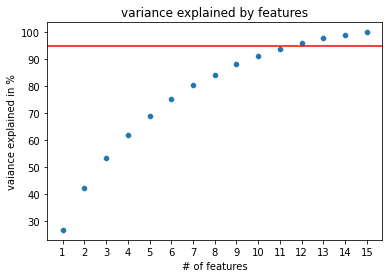

In [160]:
n=X_train_data_normalized.shape[1]
pca=PCA(n_components=n)
X_train_data_transformed=pca.fit_transform(X_train_data_normalized)
X_test_data_transformed=pca.fit_transform(X_test_data_normalized)

foo_ratio=pca.explained_variance_ratio_

# to get cummulative
var_ratio=[]
for i in range(n):
    var_ratio.append(100*sum(foo_ratio[0:i+1]))

# plotting the variance explined curve (in %)
ax=sns.scatterplot(x=np.arange(n)+1,y=var_ratio)
ax.axhline(95,color='red')
plt.title('variance explained by features')
plt.xlabel('# of features')
plt.ylabel('vaiance explained in %')
plt.xticks(np.arange(n)+1)
plt.show() # to avoid text outputs
# plt.savefig('pca.png')


**observations**

- PCA is not a good techniqe for this problem 
    - as no small number set of features explain variance quite significantly
    - if around 5-6 features would have explained around 90-95% variance then PCA would have been helpful, but that is not the case here

# functions for analysis

- function `model` uses test and train data with global scope
- these functions have been used throught the project

### function to plot coef plots for models

**`function parameters:`**
- coefDf: coef data frame with column names from project data
- name: [used as an identifier] name to be printed in plots

In [161]:
def coefplot(coefDf,name):
    # to tweak default barh visual
    kwargs={
    'alpha':0.8,
    'edgecolor':'#333',
    'facecolor':'#eef',
    'width':0.2
    }
    # to plot barh
    (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
    plt.title(f'Importance of Coeff- {name}')
    plt.xlabel("Importance")
    plt.ylabel('Features')
    plt.show()

### general function for models

**`function parameters:`**
- plot: `Bool`
    - by default is set to `False`, to plot feature coeffs set it to `True`float
- c: `float`
    - tuning hyperparameter used for SVR model, default to 0.1
- kernel: ['linear', 'poly', 'rbf', 'sigmoid']
    - kernel used for SVR model, default to `linear`
- model_title: [used as an identifier]name to be printed in plots etc
- modelName: model `class` name imported from `sklearn`

In [162]:
def model(modelName,model_title,kernel='linear',c=0.1,plot=False):
    if modelName==SVR:
        rm=modelName(kernel=kernel,C=c)
    else:
        rm=modelName()
    
    rm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    print(model_title)
    print(''.center(30,'='))
    print('Train MSE =',round(MSE_train,2))
    print('Test MSE =',round(MSE_test,2))
    print(''.center(30,'='))

    if plot==True:
        print('Relative Feature Importance Plot')
        kwargs={
            'alpha':0.8,
            'edgecolor':'#333',
            'facecolor':'#eef',
            'width':0.2
            }
        # to plot barh
        coefDf = pd.DataFrame(rm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        (coefDf['Weight of Coeff'].sort_values(ascending = False,kind='mergesort')).plot.barh(figsize=(8,8),**kwargs)
        plt.title(f'Importance of Coeff- {model_title}')
        plt.xlabel("Importance")
        plt.ylabel('Features')
        plt.show()

    return {'Model Name':model_title ,'Train':MSE_train,'Test':MSE_test}

In [163]:
# intialize lists to compare models
model_compare=[]
linear_models_compare=[]

# linear model

### normal multiple linear regression

In [164]:
lm=model(LinearRegression,'Normal Linear Regression')
model_compare.append(lm)
linear_models_compare.append(lm)

Normal Linear Regression
Train MSE = 56.27
Test MSE = 68.35


### restricted regression models

- here restricted models are, specifically: 
    - lasso(l1 norm)
    - ridge(l2 norm)
    - elastinet(l1 and l2 norm)
- we have seen linear model without any restrictions; now to try out this with restrictions we have included these models
- we will compare these models with normal linear model in two cases:
    - first case: with default alpha
    - second case: with best alpha in search space [to see if there is any improvement]

#### model names and titles

In [165]:
models=[
    {
        'title':'Lasso Regression Model',
        'name':Lasso,
        'cv':LassoCV
    },
    {
        'title':'Ridge Regression Model',
        'name':Ridge,
        'cv':RidgeCV
    },
    {
        'title':'Elastinet Regression Model',
        'name':ElasticNet,
        'cv':ElasticNetCV
    }
]

#### func used to cover with restrictions linear regression models

**`function params`**

- cvFolds: no of folds to be used to choose best alpha in search space
- title, modelName, modelCV: self-explanatory

In [166]:
# func used to cover with restrictions linear regression models
def restrictModels(title,modelName,modelCV,cvFolds=10,plot=False):
    # choosing alpha hyperparameter
    ## create search space
    r=np.linspace(-3,10,100)
    alphas=np.power(10*np.ones(100),r)
    ## get best possible alpha in search space
    rcv=modelCV(alphas=alphas,cv=cvFolds)
    rcv.fit(X_train_data_normalized,y_train_data)
    cvAlpha=rcv.alpha_

    # fit model
    rlm=modelName(alpha=cvAlpha)
    rlm.fit(X_train_data_normalized,y_train_data)

    # test mse
    preds_test=rlm.predict(X_test_data_normalized)
    MSE_test=mean_squared_error(y_test_data,preds_test)

    # train mse
    preds_train=rlm.predict(X_train_data_normalized)
    MSE_train=mean_squared_error(y_train_data,preds_train)

    # some nice formatting
    print(title)
    print(''.center(30,'='))
    print(f'CV alpha =',round(cvAlpha,2))
    print(f'Train MSE =',round(MSE_train,2))
    print(f'Test MSE =',round(MSE_test,2))
    print(''.center(30,'='))

    if plot:
        # plot
        coefDf = pd.DataFrame(rlm.coef_.T, columns=['Weight of Coeff'], index=X_train_data.columns)
        coefplot(coefDf,title)

    # return data dict
    return {'Model Name':title,'Train':MSE_train,'Test':MSE_test}

#### implementation for comparision[first case]

In [167]:
for m in models:
    linear_models_compare.append(model(m['name'],m['title']+'(first-case)'))

restrictedDf=pd.DataFrame(linear_models_compare)

Lasso Regression Model(first-case)
Train MSE = 67.98
Test MSE = 75.7
Ridge Regression Model(first-case)
Train MSE = 56.27
Test MSE = 68.37
Elastinet Regression Model(first-case)
Train MSE = 68.39
Test MSE = 77.61


#### implementation for comparision[second case]

In [168]:
for m in models:
    linear_models_compare.append(restrictModels(m['title']+'(second-case)',m['name'],m['cv']))

restrictedDf=pd.DataFrame(linear_models_compare)

Lasso Regression Model(second-case)
CV alpha = 0.01
Train MSE = 56.27
Test MSE = 68.32
Ridge Regression Model(second-case)
CV alpha = 53.37
Train MSE = 57.41
Test MSE = 69.89
Elastinet Regression Model(second-case)
CV alpha = 0.04
Train MSE = 56.4
Test MSE = 68.54


#### Observations
- although there is some improvement when using optimum alpha(i.e. second case) in restricted linear models, but not enough to surpass normal linear model
- it is quite clear from MSE errors that all restricted models perform equally well or worse than simple linear regression model, on test data
- And we shall choose model that is simple rather than complex and gives around same accuracy, 
    - Hence, we `choose normal linear regression `without any restriction on its coefficients

In [169]:
restrictedDf

,Model Name,Train,Test
0,Normal Linear Regression,56.266316,68.353944
1,Lasso Regression Model(first-case),67.983229,75.702897
2,Ridge Regression Model(first-case),56.267138,68.370663
3,Elastinet Regression Model(first-case),68.387424,77.608423
4,Lasso Regression Model(second-case),56.268864,68.319383
5,Ridge Regression Model(second-case),57.409528,69.890832
6,Elastinet Regression Model(second-case),56.398309,68.536873


# Random Forest

In [170]:
rf=model(RandomForestRegressor,'Random Forest')
model_compare.append(rf)

Random Forest
Train MSE = 8.13
Test MSE = 62.54


# Support Vector Resgression

In [173]:
svr=model(SVR,'Support Vector Resgression')
model_compare.append(svr)

Support Vector Resgression
Train MSE = 61.93
Test MSE = 72.55


### tuning hyperparameter(C) in SVR

- till now we have random forest 
- to see if SVR outperforms random after tuning `C`, we do:
    - work with bunch of different values of `C` and see if any one does better than Random Forest

In [175]:
# optimizing the parameter C in SVC
C=[0.01,0.1,1,10,100]
kernels=['linear', 'poly', 'rbf']
compare_svr=[]
for c in C:
    for k in kernels:
        compare_svr.append(model(SVR,f'SVR (C={c},kernel={k})',kernel=k,c=c))

SVR (0.1)
Train MSE = 61.93
Test MSE = 72.55
SVR (1)
Train MSE = 58.24
Test MSE = 68.27
SVR (10)
Train MSE = 58.03
Test MSE = 68.13
SVR (100)
Train MSE = 58.03
Test MSE = 68.1


# Best one: {which one}

## why this one

# feature selector

In [ ]:
def heatmap(thers):
    corr_matrix = X_train_data.corr()
    corr_matrix=corr_matrix[(corr_matrix>thers) | (corr_matrix<-thers)] # only selecte relations stronger than thersold
    mask = np.zeros_like(corr_matrix,dtype=np.bool)
    mask[np.triu_indices_from(mask)]= True

    f, ax = plt.subplots(figsize=(20, 20))

    heatmap = sns.heatmap(corr_matrix,
                        mask = mask,
                        square = True,
                        linewidths = .5,
                        cmap = 'coolwarm',
                        cbar_kws = {'shrink': .4,
                                    'ticks' : [-1, -0.5, 0, 0.5, 1]},
                        vmin = -1,
                        vmax = 1,
                        annot = True,
                        annot_kws = {'size': 12})

    #add the column names as labels
    ax.set_yticklabels(corr_matrix.columns, rotation = 0)
    ax.set_xticklabels(corr_matrix.columns)
    ax.set_title("Correlation Heatmap of Training Data",fontsize=18)
    sns.set_style({'xtick.bottom': True}, {'ytick.left': True})
    # f.savefig('correlation.jpg')

## observation for selections